### <center> Практическое задание к лекции №3

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [4]:
!pip install pandas

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion


In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\Users\Marat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

C:\Users\Marat\AppData\Local\Temp\ipykernel_7748\1317150810.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
fin_dict={
    'model':['LogReg'],
    'F-score':[fscore[ix]],
    'Precision':[precision[ix]],
    'Recall':[recall[ix]]
}

Best Threshold=0.3869370891147404, F-Score= 0.730, Precision= 0.647, Recall= 0.838


Нарисуем roc auc кривую

In [8]:
def roc_auc_plot(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.text(0,1,f'ROC-AUC_SCORE{roc_auc_score(y_test,y_score): .3f}')
    #plt.savefig("ROC.png")
    plt.show()

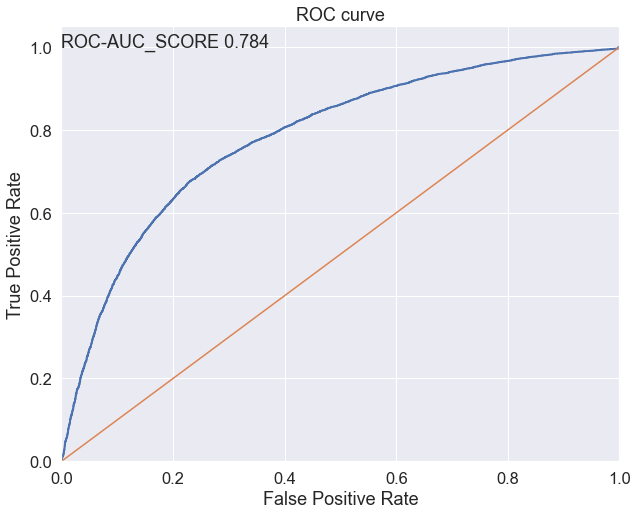

In [9]:
roc_auc_plot(y_test, y_score)

In [10]:
fin_dict.update({'ROC-AUC-SCORE':[roc_auc_score(y_test, y_score)]})

Попробуем RandomForestClassifier и CatBoostClassifier, определим лучшие параметры

#### RandomForestClassifier

In [ ]:
parameters = {
     'n_estimators': [150, 200, 300, 400, 600, 800, 1000],
     'max_depth': np.arange(5, 20, 2),
 }
clf = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=parameters, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
classifier_RF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=800, max_depth=11, random_state=0))])

In [ ]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_RF, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

#обучим пайплайн на всем тренировочном датасете
classifier_RF.fit(X_train, y_train)
y_score_rf = classifier_RF.predict_proba(X_test)[:, 1]

In [ ]:
fin_dict

In [ ]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_rf)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
new_list=['RF',fscore[ix],precision[ix], recall[ix], roc_auc_score(y_test, y_score_rf)]
for i, (key, val) in enumerate(fin_dict.items()):
    fin_dict[key].append(new_list[i])

In [ ]:
roc_auc_plot(y_test, y_score_rf)

#### GradientBoostingClassifier

In [ ]:

parameters_gb = {
     'n_estimators': [100, 150, 200, 600, 1000],
     'max_depth': np.arange(2, 10, 2),
 }
clf = GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), param_grid=parameters_gb, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
classifier_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier( max_depth=4, n_estimators=100,random_state=0))])

In [ ]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')


In [ ]:
#обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_score_gb = classifier_gb.predict_proba(X_test)[:, 1]

In [ ]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_gb)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
new_list=['GradBoost',fscore[ix],precision[ix], recall[ix], roc_auc_score(y_test, y_score_gb)]
for i, (key, val) in enumerate(fin_dict.items()):
    fin_dict[key].append(new_list[i])

In [ ]:
fin_dict

In [ ]:
roc_auc_plot(y_test, y_score_gb)

In [ ]:
res=pd.DataFrame(fin_dict).set_index('model')

In [ ]:
res

Для данной задачи наиболее важным показателем является **полнота**. Нам важно не пропустить ни одного пациента, имеющего заболевание. Поэтому из данных моделей лучше всего справились с задачей модель логистической регрессии и случайного леса.

В случае наличия сильного дисбалланса классов более правильно использовать метрику **precision_recall_curve**. Причина этого заключается в том, что, большое количество примеров класса 0 означает, что мы менее заинтересованы в умении модели правильно предсказывать класс 0, например, высокие истинные негативы. А при расчете точности и полноты не используются истинные негативы. Это касается только правильного предсказания класса меньшинства, класса 1. При этом roc_auc_curve будет  давать более оптимистичную оценку модели, слабо реагируя на соотношение классов.